# 主題 01-1. 標準神經網路做手寫辨識

## 1. 初始準備
Keras 可以用各種不同的深度學習套件當底層, 我們在此指定用 Tensorflow 以確保執行的一致性。

In [1]:
# %env是 jupyter的指令,可以用來設定環境變數

%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
# 問題：Keras有哪些 backend 呢?

再來是我們標準數據分析動作!

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 2. 讀入 MNIST 數據庫
MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 \"Modified\" 版的 MNIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的原始網頁(http://yann.lecun.com/exdb/mnist/) 。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

## 2.1 由 Keras 讀入 MNIST
Keras 很貼心的幫我們準備好 MNIST 數據庫, 我們可以這樣讀進來 (第一次要花點時間)

特別要注意的是, 萬一在讀的過程中失敗, 你需要找到下載的部份數據集刪去, 然後在一個網路通𣈱的地方再下載一次。

In [4]:
from keras.datasets import mnist

Using TensorFlow backend.


In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

查詢訓練資料是不是 6 萬筆、測試資料是不是有 1 萬筆。

In [6]:
len(x_train)   # 訓練資料數量

60000

In [7]:
len(y_train) 

60000

In [8]:
len(x_test)   # 測試資料數量

10000

In [9]:
len(y_test)  

10000

## 2.2 數據庫的內容
每筆輸入 (x) 就是一個手寫的 0-9 中一個數字的圖檔, 大小為 28x28。而輸出 (y) 當然就是「正確答案」。我們來看看編號 9487 的訓練資料。

In [10]:
x_train[9487].shape   # 圖片大小

(28, 28)

In [11]:
x_train[9487]   # 28*28的矩陣,灰階介於0~255,0是白色,255是黑色

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 240,
        253, 165,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 241,
        252, 252,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

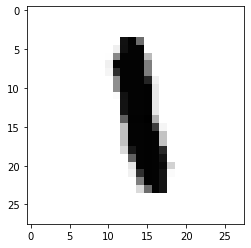

In [12]:
plt.imshow(x_train[9487], cmap="Greys")   # color maps選擇畫圖主題風格樣式

In [13]:
# 問題：還有哪些color maps呢?

我們人眼辨識就知道這是 1, 我們看答案是不是和我們想的一樣。

In [14]:
y_train[9487]

1

## 2.3 輸入格式整理
我們現在要用標準神經網路學學手寫辨識。原來的每筆數據是個 28x28 的矩陣 (array), 

但標準神經網路只吃「平平的」, 也就是每次要 28x28=784 長的向量。因此我們要用 reshape 調校一下。

In [15]:
x_train.shape   # 原本圖片大小

(60000, 28, 28)

In [16]:
x_train = x_train.reshape(60000,784)   #　標準型的NN需要將 28*28 的矩陣拉成　784　維的向量
x_test = x_test.reshape(10000,784)

# x_train = x_train / 255  將所有矩陣中的數值變成0~1之間(特徵標準化)
# x_test = x_test / 255

In [17]:
x_train.shape   # 更改後圖片大小

(60000, 784)

## 2.4 輸出格式整理

如果我們的輸入 x 是一張 0 的圖, 因為我們訓練的神經網路總會有點誤差, 所以可能會得到: 0.5

那這意思是有可能是 0, 也有可能是 1 嗎!!?? 可是 0 和 1 根本不像啊。換句話說分類的問題這樣做其實不合理!

於是我們會做 1-hot enconding, 也就是,

1 -> [ 0,1,0,0,0,0,0,0,0,0 ],

5 -> [ 0,0,0,0,0,1,0,0,0,0 ],

等等。因為分類問題基本上都要做這件事, Keras 其實已幫我們準備好套件!

In [18]:
from keras.utils import np_utils

In [19]:
y_train[9487]

1

In [20]:
y_train = np_utils.to_categorical(y_train, 10)   # 將0~9的數字做one-hot enconding(分類)
y_test = np_utils.to_categorical(y_test, 10)

In [21]:
y_train[9487]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## 3. 打造第一個神經網路
我們決定好我們的函數,而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。


## 3.1 決定神經網路架構、讀入相關套件
假如我們要這麼做:

1 使用2個 hidden layers

2 每個 hidden layer 用 500個神經元

3 Activation Function 唯一指名 sigmoid

於是從 Keras 把相關套件讀進來

In [22]:
from keras.models import Sequential   # 所有神經網路最標準型在 keras 裡面是 Sequential
from keras.layers import Dense, Activation   # Dense 最標準神經網路的形式
from keras.optimizers import SGD   # 在　Gradient Descent的標準學習法是 SGD(隨機型學習法)

## 3.2 建構我們的神經網路
和以前做迴歸或機器學習一樣, 我們就打開個「函數學習機」。標準一層一層傳遞的神經網路叫 `Sequential`, 於是我們打開一個空的神經網路

In [23]:
model = Sequential()   # 建立一個空的神經網路：模型名稱 = Sequential()

# model.add(Flatten(input_shape=(28, 28))) 將輸入曾將資料拉平

第一層 hidden layer 我們每次用add去加一層,從第一個隱藏層開始。而第一個隱藏層因為 Keras 當然猜不到輸入有幾個 features,所以我們要告訴它。

In [24]:
model.add(Dense(500,input_dim=784))   # 在模型裡面新增一層(第一層記得要在層內加上input_dim),模型名稱.add = 你要增加的層
model.add(Activation("sigmoid"))   # sigmoid 是輸出的激活函數

# 另一種寫法：model.add(Dense(500,input_dim=784,activation="sigmoid"))

第二層 hidden layer 因為前面輸出是500,現在輸入是 500,就不用再說了! 這裡的 500只告訴 Keras,我們第二層還是用 500!

In [25]:
model.add(Dense(500))
model.add(Activation("sigmoid"))

# 另一種寫法：model.add(Dense(500,activation="sigmoid"))

輸出層 output layer 輸出有10個數字,所以輸出層的神經元是10個! 而如果我們的網路輸出是[y1,y2,.....,y10],並希望輸出的所有數字加起來等於1,就用 softmax 當激發函數就可以!

In [26]:
model.add(Dense(10))   # 最後一層記得要和你要對照的答案一樣形狀
model.add(Activation("softmax"))

# 另一種寫法：model.add(Dense(10,activation="softmax"))

## 3.3 組裝
和之前比較不一樣的是我們還要做 compile 才正式把我們的神經網路建好。你可以發現我們還需要做幾件事：

1 決定使用的 loss function, 一般是 mse

2 決定 optimizer, 我們用標準的 SGD

3 設 learning rate

為了一邊訓練一邊看到結果,我們加設 metrics=["accuracy"] (本行基本上和我們的神經網路功能沒有什麼關係)

In [27]:
# 模型名稱.compile(loss=你想要用什麼樣的損失函數, optimizer=你想要用什麼方式訓練你的模型, metrics=你想增加什麼評分標準)

model.compile(loss="mse",optimizer=SGD(lr=0.1),metrics=["accuracy"])  # lr可調整

## 4. 檢視我們的神經網路
我們可以檢視我們神經網路的架構, 可以確認一下是不是和我們想像的一樣。

## 4.1 看 model 的 summary

In [28]:
# 模型名稱.summary = 將模型的結構用文字方式秀出來
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Shape：神經元的數量 ; Param：使用的參數數量
# 392500 = 784(輸入的數量)*500(神經元的數量) + 500(biases)
# 250500 = 500*500 + 500
# 5010   = 500*10  +  10

## 5. 訓練你的第一個神經網路
恭喜! 我們完成了第一個神經網路。現在要訓練的時候, 你會發現不是像以前沒頭沒腦把訓練資料送進去就好。這裡我們還有兩件事要決定:

1 決定我們一次訓練的樣本數目(batch_size), 我們就 100 筆調一次參數好了

2 這 6 萬筆資料一共要訓練幾次(epochs), 我們訓練個 20 次試試

In [30]:
model.fit(x_train, y_train, batch_size=100, epochs=20)




Epoch 1/20





60000/60000 [==============================] - 21s 358us/step - loss: 0.0832 - acc: 0.3603
Epoch 2/20
60000/60000 [==============================] - 14s 235us/step - loss: 0.0624 - acc: 0.6249
Epoch 3/20
60000/60000 [==============================] - 13s 220us/step - loss: 0.0446 - acc: 0.7677
Epoch 4/20
60000/60000 [==============================] - 15s 253us/step - loss: 0.0327 - acc: 0.8415
Epoch 5/20
60000/60000 [==============================] - 10s 171us/step - loss: 0.0256 - acc: 0.87220s - loss: 0.0257 - ac
Epoch 6/20
60000/60000 [==============================] - 12s 201us/step - loss: 0.0215 - acc: 0.8869
Epoch 7/20
60000/60000 [==============================] - 15s 251us/step - loss: 0.0189 - acc: 0.8961
Epoch 8/20
60000/60000 [==============================] - 14s 240us/step - loss: 0.0171 - acc: 0.9036
Epoch 9/20
60000/60000 [==============================] - 12s 197us/step - loss: 0.0157 - acc: 0.9099
Epoch 10/20
60000/60000 [===========================

## 6. 試用我們的結果
我們來用比較炫的方式來看看可愛的神經網路學習成果。對指令有問題可以參考我們之前的 MOOC 影片教學

In [31]:
from ipywidgets import interact_manual

我們"predict"放的是我們神經網路的學習結果。這裡用 predict_classes 會讓我們 Keras 選 10 個輸出機率最大的那類。

In [32]:
predict = model.predict_classes(x_test)

In [33]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap="Greys")
    print("神經網路判斷為:",predict[測試編號])
    
# 不要忘了我們的 x_test 每筆資料已經換成784維的向量, 我們要整型回28x28的矩陣才能當成圖形顯示出來!

In [34]:
interact_manual(test, 測試編號 = (0, 9999));

interactive(children=(IntSlider(value=4999, description='測試編號', max=9999), Button(description='Run Interact', …

到底測試資料總的狀況如何呢? 我們可以給我們神經網路「考一下試」。

In [35]:
score = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 294us/step


In [36]:
print('loss:', score[0])
print('正確率:', score[1])

loss: 0.010807674951758236
正確率: 0.9312


## 7. 訓練好的神經網路存起來!
如果對訓練成果滿意, 我們當然不想每次都再訓練一次! 我們可以把神經網路的架構和訓練好的參數都存起來, 以供日後使用!

之前還沒裝 pyh5 要在終端機(Anaconda Prompt)下安裝: conda install h5py

In [37]:
model_json = model.to_json()   # model_json可以亂取
open("handwriting_model_architecture.json", "w").write(model_json)   # 儲存神經網路架構
model.save_weights("handwriting_model_weights.h5")   # 儲存神經網路 weights

# 主題 01-2. 取回訓練好的神經網路

In [38]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## 1. 找回我們的神經網路
我們這裡需要把結構和 weights 取回, 要注意的是還需要再 compile 一次, 所以在 complie 中用到的 optimizer 等還是需要告訴 Keras 的。

In [39]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [40]:
from keras.models import model_from_json
from keras.optimizers import SGD

In [41]:
# 讀取神經網路架構與權重

model = model_from_json(open('handwriting_model_architecture.json').read())
model.load_weights('handwriting_model_weights.h5')

In [42]:
# 組裝

model.compile(loss='mse', optimizer=SGD(lr=0.1))

## 2. 資料再讀回來

In [43]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [44]:
x_train = x_train.reshape(60000,784) # 將資料轉成784維向量
x_test = x_test.reshape(10000, 784)

## 3. 找一個來試試

In [45]:
# n_test = 1234
n_test=9487

In [46]:
x = x_test[n_test]

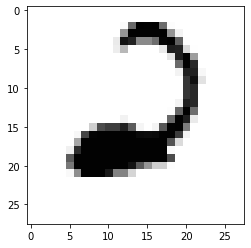

In [47]:
plt.imshow(x.reshape(28,28), cmap='Greys')

In [48]:
model.predict_classes(x.reshape(1,784))   # predict_classes會讓我們 Keras選 10個輸出機率最大的那類

array([2], dtype=int64)